In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import MSA as msa # Импорт модуля стандартной атмосферы

%config InlineBackend.figure_format = 'svg'

In [2]:
# Функции для расчета

# Зависимость приведенной скорости потока от числа Маха
def get_lam_M(k, M):
    """
    Расчет приведенной скорости полета
        Аргументы:
            - M (float) - число Маха;
            - k (float) - показатель адиабаты;
        Результат:
            - lam (float) - приведенная скорость полета.
    """
    return np.sqrt((((k+1) / 2) * M**2) / (1+((k-1) / 2)*M**2))

# Газодинамическая фунция pi(lambda)
def get_pi(k, lam):
    """
    Газодинамическая функция pi
        Аргументы:
            - k (float) - показатель адиабаты;
            - lam (float) - приведенная скорость полета;
        Результат:
            - pi (float) - значение ГД функции.
    """
    return (1-((k-1) / (k+1))*lam**2) ** (k/(k-1))

# газодинамическая функция q(lambda)
def get_q(k, lam):
    """
    Газодинамическая функция q
        Аргументы:
            - k (float) - показатель адиабаты;
            - lam (float) - приведенная скорость полета;
        Результат:
            - q (float) - значение ГД функции.
    """
    return (((k+1)/2)**(1/(k-1)))*((1-((k-1)*lam**2)/(k+1))**(1/(k-1)))*lam

def get_tau(k, lam):
    """
    Газодинамическая функция tau
        Аргументы:
            - k (float) - показатель адиабаты;
            - lam (float) - приведенная скорость полета;
        Результат:
            - tau (float) - значение ГД функции.
    """
    return 1 - ((k-1) * lam**2) / (k+1)

In [3]:
# Термодмнамические параметры воздуха и газа

# тдх воздуха 
k = 1.4 # Показатель адиабаты воздуха
R = 287 # Газовая постоянная воздуха
cp = 1005 # Теплоемкость воздуха

# тдх газа
k_g = 1.33 # Показатель адиабаты воздуха
R_g = 293 # Газовая постоянная воздуха
cp_g = 1165 # Теплоемкость воздуха

In [4]:
# Расчет ТРДД
# Ведется по параметрам заторможенного потока последовательно от сечения к сечению

# 1. Параметры полета
M_n = 0.7 # Число Маха полета
H = 1500 # м, высота полета
P = 4e3 # Тяга двигателя

# 2. Определение параметров по стандратной атмосфере
a = msa.get_atm_params(H)['a'] # Скорость звука на высоте H
p_n = msa.get_atm_params(H)['p'] # Статическое давление на высоте H
T_n = msa.get_atm_params(H)['T'] # Статическая температура на высоте Н

# 3. Расчет скорости полета
V_n = M_n * a # Число Маха

# 4. К-т восстановления полного давления по входной устройстве
sigma_vh = 0.97 # для реального входного устройства

# 5. Приведенная скорость полета
lambda_n = get_lam_M(k, M_n)

# 6. ГД функции

# 7. Полное давлениеи температура торможения на входе в вентилятор
p_v_zv = p_n*sigma_vh/get_pi(k, lambda_n)
T_v_zv = T_n / get_tau(k, lambda_n)

# 8. Полное давление и темепратура торможения за вентилятором
pi_v_zv = 1.9 # с. 22 книга
eta_v = 0.835 # с. 22 книга

p_vn_zv = p_v_zv * pi_v_zv
T_vn_zv = T_v_zv * (1 + (pi_v_zv**((k-1) / k) - 1) / eta_v)

# 9. Полное давление и температура торможения за компрессором
pi_k_zv = 12.5 # с. 22 книга
eta_k = 0.8 # !!!

p_k_zv = p_vn_zv * pi_k_zv
T_k_zv = T_vn_zv * (1 + (pi_k_zv**((k-1) / k) - 1) / eta_k)

# 10. Полное давление газа перед турбиной
sigma_kc = 0.95 # c. 22 книга

p_g_zv = p_k_zv * sigma_kc

# 11. Относительный расход топлива в камере сгорания
T_g_zv = 1700 # К, Темпетратура газа перед турбиной
eta_g=0.99 # [0.98...0.99] К-т полноты сгорания

def get_q_t(T_g_zv, T_k_zv, H_u=42900, T0=293):
    '''
    Относительный расход топлива в камере сгорания (формула Я.Т. Ильичева)
        Аргументы:
            T_g_zv (float) - температура газа перед турбиной, К
            T_k_zv (float) - температура торможения за компрессором, К
        Результат:
            q_t (float) - относительный расход в камере сгорания
    '''
    def get_cpT_zv(T_zv):
        return 4*1e-5*T_zv**2+1.0795*T_zv-59.843
    def get_cp_p_zv(T_zv):
        return 0.0004*T_zv**2+2.1436*T_zv-281.82
    q_t=(get_cpT_zv(T_g_zv) - get_cpT_zv(T_k_zv))/(H_u*eta_g-get_cp_p_zv(T_g_zv)+get_cp_p_zv(T0))
    return q_t

q_t = get_q_t(T_g_zv, T_k_zv)

# 12. Степень понижения дваления на турбине компрессора pi_tk_zv
eta_tk_zv = 0.93 #  c. 22 книга
delta_otb = 0.03 # c. 22 книга
eta_mk = 0.995 # Механический КПД # c. 22 книга

X_tk = (cp* (T_k_zv - T_v_zv)) / (cp_g*T_g_zv*eta_tk_zv*(1+q_t)*(1-delta_otb)*eta_mk)
pi_tk_zv = (1 - X_tk)**(-k_g / (k_g-1))

# 13. Полное давление и температура торможения за турбиной компрессора
p_tk_zv = p_g_zv / pi_tk_zv
T_tk_zv = T_g_zv * (1 - X_tk*eta_tk_zv)

# 14. Степень понижения давления на тубине вентилятора
eta_tv_zv = 0.995 # c. 22 книга
eta_mv=0.995 # Механический КПД # c. 22 книга
m = 3 # Степень двухконтурности с. 22 книга

X_tv = (cp* (1 + m) * (T_vn_zv - T_v_zv)) / (cp_g*T_tk_zv*eta_tv_zv*(1 + q_t)*(1 - delta_otb)*eta_mv)
pi_tv_zv = (1 - X_tv)**(-k_g / (k_g-1))

# 15. Полное давление и температура торможения за турбиной вентилятора
p_t_zv = p_tk_zv / pi_tv_zv
T_t_zv = T_tk_zv * (1 - X_tv*eta_tv_zv)

# 16. Приведенная изоэнтропическая скорость истечения газа из реактивного сопла внутреннего контура
# Реактивное сопло сужающееся

def for_lam_cIs(lam):
    return - p_n/p_t_zv + get_pi(k_g, lam)

lam_cIs = fsolve(for_lam_cIs, 0.5)[0]

if (lam_cIs <= 1):
    type_rash = 'полное расширение'
    # 17. Приведенная скорость истечения газа из сопла вн. контура
    phi_cI = 0.985 # c. 22 книга
    lam_cI = lam_cIs * phi_cI
    # 18. Полное давление на срезе сопла внутреннего контура
    p_cI_zv = p_n / get_pi(k_g, lam_cI)
elif (lam_cIs > 1):
    type_rash = 'неполное расширение'
    # 19. Приведенная изоэнтропическая скорость истечения из сопла внутреннего контура и статическое давление на срезе сопла
    lam_cIs = 1
    p_cI = p_t_zv * get_pi(k_g, 1)

    # 20. Приведенная скорость истечения из сопла внутреннего контура
    phi_cI = 0.985 # c. 22 книга
    lam_cI = phi_cI

    # 21. Избыточное статическое давление на срезе сопла внутреннего контура
    delta_p_cI = p_cI - p_n

    # 22. Полное давление на срезе сопла внутреннего контура
    p_cI_zv = p_cI / get_pi(k_g, lam_cI)

# 23. Скорость истечения газа из реактивного сопла внутри контура
c_cI = np.sqrt(2*k_g*R_g/(k_g+1)) * lam_cI * np.sqrt(T_t_zv)

# 24. Эквивалеьная скорость истечения газа из сопла внутреннего контура
c_cI_ = c_cI + ((np.sqrt(T_t_zv) * (p_cI - p_n)) / (0.0397 * get_q(k_g, lam_cI) * p_cI_zv))

# 25. Удельная тяга внутреннего контура
P_ud_I = (1 + q_t*(1 - delta_otb))*c_cI_ - V_n

# 26. Полное давление на входе в сопло наружного контура
# К-т восстановления полного давления в наружном контуре
sigma_II = 0.960 # c.22 книга
p_II_zv = p_vn_zv * sigma_II

# 27. Приведенная изоэнтропическая скорость истечения воздуха из реактивного сопла наружного контура
def for_lam_cII_s(lam):
    return get_pi(k_g, lam) - p_n/p_II_zv
lam_cII_s = fsolve(for_lam_cII_s, 1)[0]

if (lam_cII_s <= 1):
    type_rash_II = 'полное расширение в сопле'
    # 28. Приведенная скорость истечения воздуха из сопла наружного контура
    # К-т скорости при истечении из сопла наружного контура
    phi_cII = 0.98 # c. 22 книга
    lam_cII = lam_cII_s * phi_cII

    # 29. Полное давление на срезе сопла наружного контура
    p_cII_zv = p_n / get_pi(k_g, lam_cII)

elif (lam_cII_s > 1):
    type_rash_II = 'НЕполное расширение в сопле'
    # 30. Приведенная изоэнтропическая скорость истечения из сопла наружного контура и статическое давление на срезе сопла
    lam_cII_s = 1
    p_cII = p_II_zv * get_pi(k_g, 1)

    # 31. Приведенная скорость истечения из сопла наружного контура
    phi_cII = 0.98 # c. 22 книга
    lam_cII = phi_cII

    # 32. Избыточное статическое давление на срезе сопла наружного контура
    delta_p_cII = p_cII - p_n

    # 33. Полное давление на срезе сопла наружного контура
    p_cII_zv = p_cII / get_pi(k_g, lam_cII)

# 34. Скорость истечения воздуха из сопла наружного контура
c_cII = np.sqrt(2*k_g*R_g / (k_g+1)) * lam_cII * np.sqrt(T_t_zv)

# 35. Эквивалентная скорость истечения воздуха из сопла наружного контура
c_cII_ = c_cII + ((np.sqrt(T_vn_zv) * (p_cII - p_n)) / (0.0404 * get_q(k_g, lam_cII) * p_cII_zv))

# 36. Удельная тяга наружного контура
P_ud_II = c_cII_ - V_n

# 37. Удельная тяша двигателя с разудльными контурами
P_ud = (P_ud_I + m*P_ud_II) / (1 + m)

# 38. Удельный расход топлива
C_ud = 3600 * (q_t * (1 - delta_otb)) / (P_ud * (1 + m))

# 39. Расход воздуха через двигатель
G_v = P / P_ud

# 41. Эффективная работа цикла двигателя
L_e = 0.5 * ((1 + q_t * (1-delta_otb))*c_cI_**2 + m*c_cII_**2 - (1+m)*V_n**2)

# 42. Эффективный КПД двигателя
H_u = 42900 # для керосина
eta_e = L_e / (q_t * (1 - delta_otb) * H_u * 1e3)

# 43. Полный КПД двигателя
eta_n = ((1 + m) * P_ud * V_n) / L_e

# 44. Общий КПД двигателя
eta_o = eta_e * eta_n

In [5]:
# Определение удельной массы двигателя для случая M_n_ = 0 H_ = 0

# 45. Эквивалентая степень повышения давления
pi_ke = (pi_k_zv**((k-1)/k) + m * (pi_v_zv**((k-1)/k) - 1))**(k/(k-1))

# 46. Относительная масса турбокомпрессора обобщенного двигателя
mu_dvI_ = 6.49 + 0.386*pi_ke

# 47. К-ты влияния на удельную массу двигателя
# К-т учитывающий совершенства массы ГТД по годам
YEAR = 2023
K_c = 1 / (-20.6368 + 0.010855 * YEAR)

# Нет реверсивного устройства
K_rev = 1

# ТРДД
K_res = 1

# Нормальный прогноз
K_opt = 1

# 48. Относительная масса и масса двигателя
mu_dv = mu_dvI_ * K_c * K_rev * K_res * K_opt / (m+1)
M_dv = mu_dv * G_v

# 49. Удельная масса двигателя
gamma_dv = M_dv / P

In [13]:
# Функция для расчета ТГД параметров ТРДД

M_n = 0.7 # Число М полета
H = 1500 # Высота полета, м
P = 4e3 # Тяга, Н
sigma_vh = 0.97 # К-т восстановления полного давления во вх. устройстве
pi_v_zv = 1.9 # Степень повышения давления в вентиляторе
eta_v = 0.835 # КПД вентилятора
pi_k_zv = 12.5 # Степень повышения полного давления воздуха в компрессоре
eta_k = 0.8 # КПД компрессора
sigma_kc = 0.95 # К-т восстановления полного давления в основной камере сгорания
T_g_zv = 1700 # Температура торможения за камерой сгорания, К
eta_g = 0.99 # К-т полноты сгорания в основной камере
eta_tk_zv = 0.93 #  КПД турбины компрессора
delta_otb = 0.03 # Доля воздуха, отбираемого на охлаждение турбины
eta_mk = 0.995 # Механические КПД турбины компрессора
eta_tv_zv = 0.995 # КПД турбины вентилятора
eta_mv = 0.995 # Механический КПД турбины вентилятора
m = 3 # Степень двухконтурности
sigma_II = 0.960 # К-т восстановления полного давления в наружном контуре
phi_cI = 0.985 # К-т скорости при истечении из сопла внутреннего контура
phi_cII = 0.98 # К-т скорости при истечении из сопла наружного контура
H_u = 42900 # Удельная теплота сгорания керосина, кДж/кг
YEAR = 2023 # Год начала летных испытаний двигателя

# Словарь исходных данных для расчета
init = {'M_n': M_n,
        'H': H,
        'P': P,
        'sigma_vh': sigma_vh,
        'pi_v_zv': pi_v_zv,
        'eta_v': eta_v,
        'pi_k_zv': pi_k_zv,
        'eta_k': eta_k,
        'sigma_kc': sigma_kc,
        'T_g_zv': T_g_zv,
        'eta_g': eta_g,
        'eta_tk_zv': eta_tk_zv,
        'delta_otb': delta_otb,
        'eta_mk': eta_mk,
        'eta_tv_zv': eta_tv_zv,
        'eta_mv': eta_mv,
        'm': m,
        'sigma_II': sigma_II,
        'phi_cI': phi_cI,
        'phi_cII': phi_cII,
        'H_u': H_u,
        'YEAR': YEAR}

def get_params_TRDD(init):
    """Расчет термогазодинамических характеристик ТРДД

    Parameters
    ----------
    dict
        словарь следующего вида:
        {
            'M_n': float
                Число Маха полета
            'H': float
                Высота полета, м
            'P': float
                Тяга, Н
            'sigma_vh': float
                К-т восстановления полного давления во вх. устройстве
            'pi_v_zv': float
                Степень повышения давления в вентиляторе
            'eta_v': float
                КПД вентилятора
            'pi_k_zv': float
                Степень повышения полного давления воздуха в компрессоре
            'eta_k': float
                КПД компрессора
            'sigma_kc': float
                К-т восстановления полного давления в основной камере сгорания
            'T_g_zv': float
                Температура торможения за камерой сгорания, К
            'eta_g': float
                К-т полноты сгорания в основной камере
            'eta_tk_zv': float
                КПД турбины компрессора
            'delta_otb': float
                Доля воздуха, отбираемого на охлаждение турбины
            'eta_mk': float
                Механические КПД турбины компрессора
            'eta_tv_zv': float
                КПД турбины вентилятора
            'eta_mv': float
                Механический КПД турбины вентилятора
            'm': float
                Степень двухконтурности
            'sigma_II': float
                К-т восстановления полного давления в наружном контуре
            'phi_cI': float
                К-т скорости при истечении из сопла внутреннего контура
            'phi_cII': float
                К-т скорости при истечении из сопла наружного контура
            'H_u': float
                Удельная теплота сгорания керосина, кДж/кг  
        }

    Returns
    -------
    dict
        словарь следующего вида:
        {
            'P_ud': float
                Удельная тяга двигателя, м/с
            'C_ud': float
                Удельный расход топлива, ?
            'G_v': float
                Расход воздуха через двигатель, кг/с
        }
    """

    # Распаковка словаря
    M_n, H, P, sigma_vh, pi_v_zv, eta_v, pi_k_zv, eta_k, sigma_kc, T_g_zv, eta_g, eta_tk_zv, delta_otb, eta_mk, eta_tv_zv, eta_mv, m, sigma_II, phi_cI, phi_cII, H_u, YEAR = \
    list((init.values()))
    
    a = msa.get_atm_params(H)['a'] # Скорость звука на высоте H
    p_n = msa.get_atm_params(H)['p'] # Статическое давление на высоте H
    T_n = msa.get_atm_params(H)['T'] # Статическая температура на высоте Н
    V_n = M_n * a # Число Маха
    lambda_n = get_lam_M(k, M_n)
    p_v_zv = p_n*sigma_vh/get_pi(k, lambda_n)
    T_v_zv = T_n / get_tau(k, lambda_n)
    p_vn_zv = p_v_zv * pi_v_zv
    T_vn_zv = T_v_zv * (1 + (pi_v_zv**((k-1) / k) - 1) / eta_v)
    p_k_zv = p_vn_zv * pi_k_zv
    T_k_zv = T_vn_zv * (1 + (pi_k_zv**((k-1) / k) - 1) / eta_k)
    p_g_zv = p_k_zv * sigma_kc
    def get_q_t(T_g_zv, T_k_zv, H_u=42900, T0=293):
        '''
        Относительный расход топлива в камере сгорания (формула Я.Т. Ильичева)
            Аргументы:
                T_g_zv (float) - температура газа перед турбиной, К
                T_k_zv (float) - температура торможения за компрессором, К
            Результат:
                q_t (float) - относительный расход в камере сгорания
        '''
        def get_cpT_zv(T_zv):
            return 4*1e-5*T_zv**2+1.0795*T_zv-59.843
        def get_cp_p_zv(T_zv):
            return 0.0004*T_zv**2+2.1436*T_zv-281.82
        q_t=(get_cpT_zv(T_g_zv) - get_cpT_zv(T_k_zv))/(H_u*eta_g-get_cp_p_zv(T_g_zv)+get_cp_p_zv(T0))
        return q_t
    q_t = get_q_t(T_g_zv, T_k_zv)
    X_tk = (cp* (T_k_zv - T_v_zv)) / (cp_g*T_g_zv*eta_tk_zv*(1+q_t)*(1-delta_otb)*eta_mk)
    pi_tk_zv = (1 - X_tk)**(-k_g / (k_g-1))
    p_tk_zv = p_g_zv / pi_tk_zv
    T_tk_zv = T_g_zv * (1 - X_tk*eta_tk_zv)
    X_tv = (cp* (1 + m) * (T_vn_zv - T_v_zv)) / (cp_g*T_tk_zv*eta_tv_zv*(1 + q_t)*(1 - delta_otb)*eta_mv)
    pi_tv_zv = (1 - X_tv)**(-k_g / (k_g-1))
    p_t_zv = p_tk_zv / pi_tv_zv
    T_t_zv = T_tk_zv * (1 - X_tv*eta_tv_zv)
    def for_lam_cIs(lam):
        return - p_n/p_t_zv + get_pi(k_g, lam)
    lam_cIs = fsolve(for_lam_cIs, 0.5)[0]
    if (lam_cIs <= 1):
        type_rash = 'полное расширение'
        lam_cI = lam_cIs * phi_cI
        p_cI_zv = p_n / get_pi(k_g, lam_cI)
        p_cI = p_n
    elif (lam_cIs > 1):
        type_rash = 'неполное расширение'
        lam_cIs = 1
        p_cI = p_t_zv * get_pi(k_g, 1)
        lam_cI = phi_cI
        delta_p_cI = p_cI - p_n
        p_cI_zv = p_cI / get_pi(k_g, lam_cI)
    c_cI = np.sqrt(2*k_g*R_g/(k_g+1)) * lam_cI * np.sqrt(T_t_zv)
    c_cI_ = c_cI + ((np.sqrt(T_t_zv) * (p_cI - p_n)) / (0.0397 * get_q(k_g, lam_cI) * p_cI_zv))
    P_ud_I = (1 + q_t*(1 - delta_otb))*c_cI_ - V_n
    p_II_zv = p_vn_zv * sigma_II
    def for_lam_cII_s(lam):
        return get_pi(k_g, lam) - p_n/p_II_zv
    lam_cII_s = fsolve(for_lam_cII_s, 1)[0]
    if (lam_cII_s <= 1):
        type_rash_II = 'полное расширение в сопле'
        lam_cII = lam_cII_s * phi_cII
        p_cII_zv = p_n / get_pi(k_g, lam_cII)
        p_cII = p_n
    elif (lam_cII_s > 1):
        type_rash_II = 'НЕполное расширение в сопле'
        lam_cII_s = 1
        p_cII = p_II_zv * get_pi(k_g, 1)
        lam_cII = phi_cII
        delta_p_cII = p_cII - p_n
        p_cII_zv = p_cII / get_pi(k_g, lam_cII)
    c_cII = np.sqrt(2*k_g*R_g / (k_g+1)) * lam_cII * np.sqrt(T_t_zv)
    c_cII_ = c_cII + ((np.sqrt(T_vn_zv) * (p_cII - p_n)) / (0.0404 * get_q(k_g, lam_cII) * p_cII_zv))
    P_ud_II = c_cII_ - V_n
    P_ud = (P_ud_I + m*P_ud_II) / (1 + m)
    C_ud = 3600 * (q_t * (1 - delta_otb)) / (P_ud * (1 + m))
    G_v = P / P_ud
    L_e = 0.5 * ((1 + q_t * (1-delta_otb))*c_cI_**2 + m*c_cII_**2 - (1+m)*V_n**2)
    H_u = 42900 # для керосина
    eta_e = L_e / (q_t * (1 - delta_otb) * H_u * 1e3)
    eta_n = ((1 + m) * P_ud * V_n) / L_e
    eta_o = eta_e * eta_n
    result={}
    result['P_ud'] = P_ud
    result['C_ud'] = C_ud
    result['G_v'] = G_v
    return result


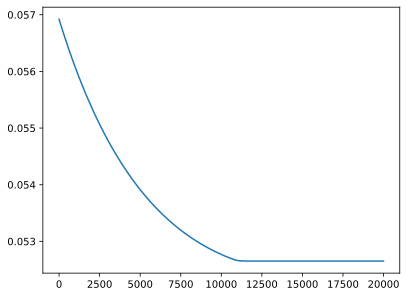

In [7]:
# Построение зависимости P_ud (H)
Htab = np.linspace(0, 20e3, 100)
Pudtab = []
Cudtab = []

for Htek in Htab:
    init['H'] = Htek
    res = get_params_TRDD(init)
    Pud = res['P_ud']
    Cud = res['C_ud']
    Pudtab.append(Pud)
    Cudtab.append(Cud)
init['H'] = H
plt.plot(Htab, Cudtab)

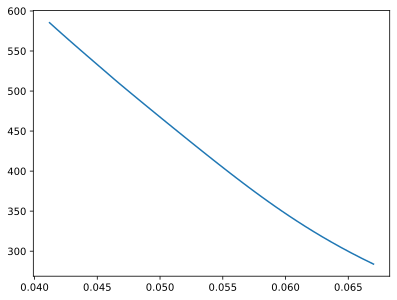

In [19]:
# Построение зависимости P_ud (H)
Mtab = np.linspace(0, 1.1)
Pudtab = []
Cudtab = []

for Mtek in Mtab:
    init['M_n'] = Mtek
    res = get_params_TRDD(init)
    Pud = res['P_ud']
    Cud = res['C_ud']
    Pudtab.append(Pud)
    Cudtab.append(Cud)
init['M_n'] = M_n
plt.plot(Cudtab, Pudtab)